## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

In [9]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
%matplotlib inline

In [10]:
# Read all the chessboard images in for camera calibration
filenames = []
for filename in glob.glob('camera_cal/calibration*'):
    filenames.append(filename)

In [15]:
# Convert to grayscale
images = cv2.imread(filenames[2])
gray = cv2.cvtColor(images, cv2.COLOR_BGR2GRAY)

In [16]:
# Find the chessboard corners
nx = 9
ny = 6
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

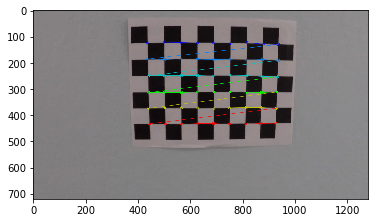

In [17]:
# If found, draw corners and display
if ret == True:
    cv2.drawChessboardCorners(images, (nx, ny), corners, ret)
    plt.imshow(images)

In [25]:
def camera_calibration(filename, nx=9, ny=6):
    image = cv2.imread(filename)
    # Grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Find corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    # Draw corners and display
    cv2.drawChessboardCorners(image, (nx, ny), corners, ret)
    plt.figure()
    return plt.imshow(image)

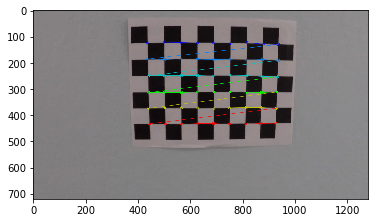

In [26]:
camera_calibration(filenames[2])